**1번문제**

고양이와 개 이미지 분류하기

**Kaggle Dogs Vs. Cats 데이터셋 준비하기**

In [ ]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2021-05-24 08:15:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.167.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  99.7MB/s    in 0.7s    

2021-05-24 08:15:03 (99.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



**압축풀기**

데이터셋의 압축되어있기 때문에 압축을 풉니다.

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

경로 지정하기

기본경로와 훈련을 시킬 경로를 각각 지정해줍니다.

In [ ]:
# 기본 경로
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


**Kaggle Dogs Vs. Cats 데이터셋 살펴보기**

개와 고양이의 데이터셋을 확인합니다.

os.listdir() 메서드는 경로 내에 있는 파일의 이름을 리스트의 형태로 반환합니다.

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.624.jpg', 'cat.837.jpg', 'cat.313.jpg', 'cat.16.jpg', 'cat.403.jpg']
['dog.507.jpg', 'dog.676.jpg', 'dog.859.jpg', 'dog.300.jpg', 'dog.321.jpg']


리스트의 길이(len)을 활용해

데이터의 총량을 확인해줍니다.

In [ ]:
print('Total training cat images :', len(os.listdir(train_cats_dir)))
print('Total training dog images :', len(os.listdir(train_dogs_dir)))

print('Total validation cat images :', len(os.listdir(validation_cats_dir)))
print('Total validation dog images :', len(os.listdir(validation_dogs_dir)))

Total training cat images : 1000
Total training dog images : 1000
Total validation cat images : 500
Total validation dog images : 500


개와 고양이의 이미지를 확인합니다.

matplotlib를 활용하며 사진을 출력합니다

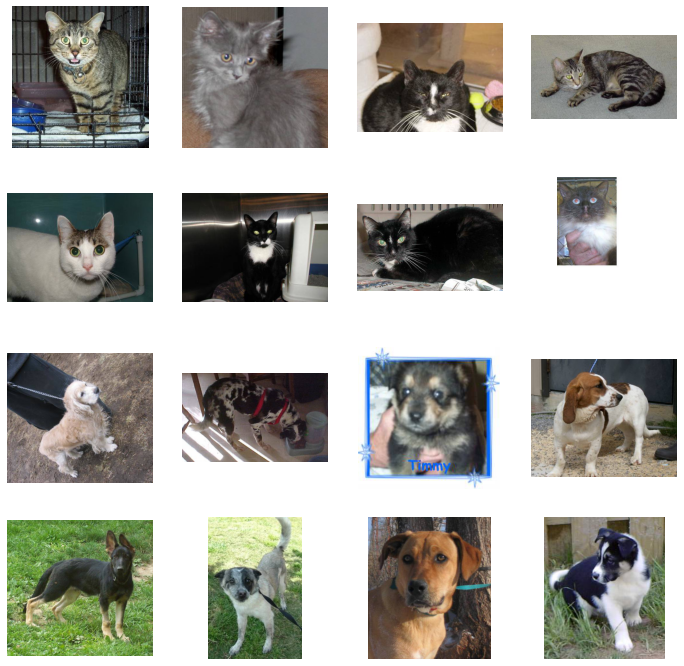

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

텐서플로우를 활용하여 모델을 구성합니다.

summary() 메서드를 이용해서 신경망의 구조를 확인할 수 있습니다.

In [ ]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

모델을 컴파일 해줍니다.

loss fuchion과 optimizer를 작성합니다.

loss fuchion은 binary_crossentropy를 사용하였습니다.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics = ['accuracy'])

**이미지 데이터 전처리하기**

학습을 위해 이미지 데이터를 전처리 해줍니다.

ImageDataGenerator 객체의 rescale 파라미터를 이용해서 모든 데이터를 255로 나누어준 다음,

flow_from_directory() 메서드를 이용해서 훈련과 테스트에 사용될 이미지 데이터를 만듭니다.

첫번째 인자로 이미지들이 위치한 경로를 입력하고, batch_size, class_mode를 지정합니다.

target_size에 맞춰서 이미지의 크기가 조절됩니다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


모델 훈련하기

fit() 메서드는 앞에서 구성한 Neural Network 모델을 훈련합니다.

훈련과 테스트를 위한 데이터셋인 train_generator, validation_generator를 입력합니다.

epochs는 데이터셋을 한 번 훈련하는 과정을 의미합니다.(100회)

steps_per_epoch는 한 번의 에포크 (epoch)에서 훈련에 사용할 배치 (batch)의 개수(100)를 지정합니다.

validation_steps는 한 번의 에포크가 끝날 때, 테스트에 사용되는 배치 (batch)의 개수(50)를 지정합니다.

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    verbose=2)

Epoch 1/100
100/100 - 40s - loss: 0.7643 - accuracy: 0.5860 - val_loss: 0.6615 - val_accuracy: 0.5640
Epoch 2/100
100/100 - 10s - loss: 0.5902 - accuracy: 0.6920 - val_loss: 0.8685 - val_accuracy: 0.5720
Epoch 3/100
100/100 - 10s - loss: 0.5086 - accuracy: 0.7545 - val_loss: 0.5447 - val_accuracy: 0.7290
Epoch 4/100
100/100 - 10s - loss: 0.4260 - accuracy: 0.8135 - val_loss: 0.5434 - val_accuracy: 0.7370
Epoch 5/100
100/100 - 10s - loss: 0.3215 - accuracy: 0.8590 - val_loss: 0.5744 - val_accuracy: 0.7490
Epoch 6/100
100/100 - 10s - loss: 0.2371 - accuracy: 0.9010 - val_loss: 0.6865 - val_accuracy: 0.7090
Epoch 7/100
100/100 - 10s - loss: 0.1469 - accuracy: 0.9400 - val_loss: 0.8382 - val_accuracy: 0.7190
Epoch 8/100
100/100 - 10s - loss: 0.1038 - accuracy: 0.9625 - val_loss: 1.0412 - val_accuracy: 0.7280
Epoch 9/100
100/100 - 10s - loss: 0.0948 - accuracy: 0.9670 - val_loss: 0.9653 - val_accuracy: 0.7320
Epoch 10/100
100/100 - 10s - loss: 0.0561 - accuracy: 0.9810 - val_loss: 1.1399 - 

정확도와 손실도를 표시합니다

matplotlib를 활용하여 그래프로 나타내어 줍니다.

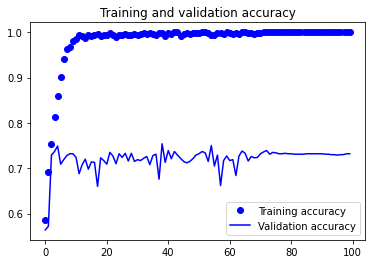

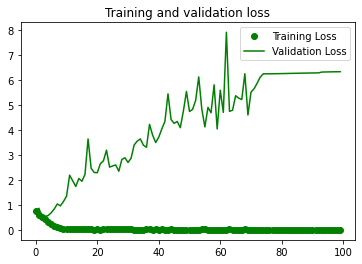

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프를 해석합니다.

20회 에포크에서 훈련 정확도는 1.0에 근접한 반면, 테스트의 정확도는 100회 훈련이 끝나도 0.7 수준에 머물고 있습니다.

즉 과적합 상태가 일어났다고 할 수 있습니다.

**결과 확인**

실제로 분류가 잘되는지 이미지를 활용하여 확인합니다.

넘파이와 구글코랩이 제공하는 파일 업로드 기능을 사용합니다.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dog.jpg to dog.jpg
[1.]
dog.jpg is a dog


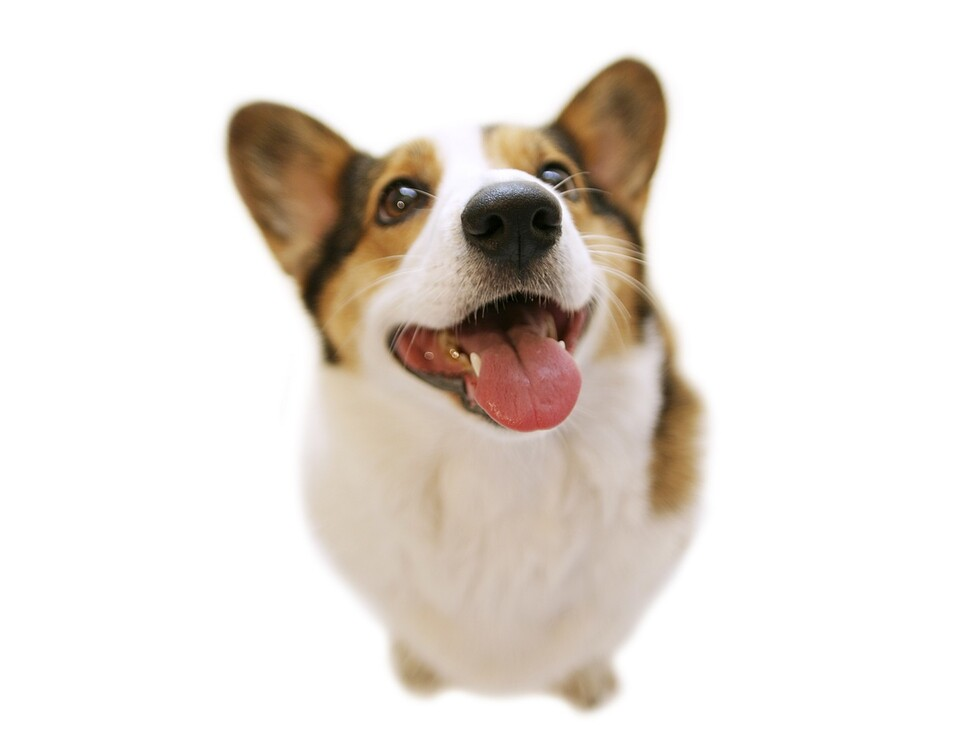

해당 사진을 입력시켜본 결과 올바른 결과를 도출하였습니다.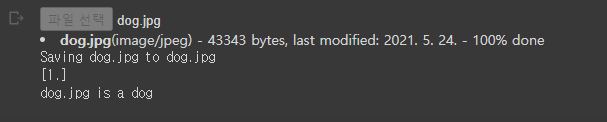

추가실험)

만약 손실함수를 이진분류가 아닌 다른것을 사용한다면 어떻게 될까?

이진분류가 아닌 다른 함수를 손실함수로 사용하여 대입해 보겠습니다.


In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
            loss='mean_squared_error',
            metrics = ['accuracy'])

평균제곱오차(mean_squared_error)를 한번 대입해 보았습니다

평균제곱오차는 오차의 제곱에 대해 평균을 취한 것으로

그 값이 작을 수록 정확도가 높아집니다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**위의 내용과 동일한 조건에서 코드를 입력하여 진행하였습니다.**

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    verbose=2)

Epoch 1/100
100/100 - 11s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 2/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 3/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 4/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 5/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 6/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 7/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 8/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 9/100
100/100 - 10s - loss: 4.4268e-21 - accuracy: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.7320
Epoch 10/100
100/100 - 10s - loss: 4.4268e-21 

**코드를 학습시키는 과정까지는 에러가 발생하지 않았습니다.**

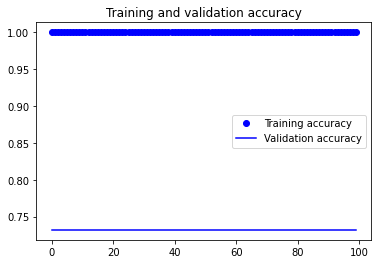

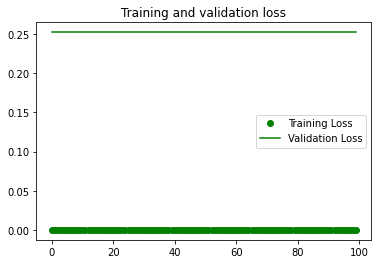

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그러나 그래프 부분에서 훈련정확도는 1로 표기되는반면

테스트의 정확도는 0에 머무르며 올바른 작동이 되지 않는것을 알 수 있습니다.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat1.jpg to cat1 (4).jpg
[1.]
cat1.jpg is a dog


위와 같은 사진을 대입하여

결과를 출력하였지만 동일한 결과가 나왔습니다.

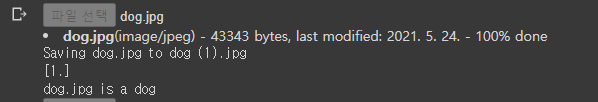

**실험결과)**

추가실험으로 다른 로스함수를 대입하였을때

원래의 과정보다 그렇게 좋은결과를 내었다고 하기는 어려웠습니다.

2가지의 사진을 분류할때는 이진분류를 사용하는것이 더 좋은 것 같습니다.

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split

s=svm.SVC(gamma = 0.001)
s.fit(train_cat_fnames, train_dog_fnames)
val_mse, val_mae, val_mape, val_acc = model.evaluate(test_x, test_y, verbose=0)

NameError: ignored